In [1]:
%load_ext autoreload
%autoreload 2

# Load packages
import numpy as np
import sde_solvers as sde
from scipy import stats
import matplotlib.pyplot as plt
import stochastic_plots as stoch

# Euler integration scheme for ODE's

In [2]:
def ode_euler(t0, x0, T, a, N):
    
    """ Integration of an ODE using the Euler scheme """

    dT = T / N # size of simulation step
    
    # Initialize solution array
    t = np.linspace(t0, t0+T, N+1) # integration grid
    x = np.zeros(N+1)
    
    # Initial condition
    x[0] = x0
 
    # Integration of the ODE
    for n in range(N):
        x[n+1] = x[n] + a(t[n], x[n])*dT
        
    return (t, x)

# Integration schemes for SDE's

In [3]:
# Define SDE
mu = 1.3
sigma = 0.4

def a(t, x): 
    return mu*x

def b(t,x): 
    return sigma*x

def db_dx(t,x): 
    return sigma

# Define initial conditions
t0, X0 = 0.0, 100.0

# Define the simulation parameters 
M = 10000  # Number of trajectories for simulation
T = 10.0  # Length of simulation interval

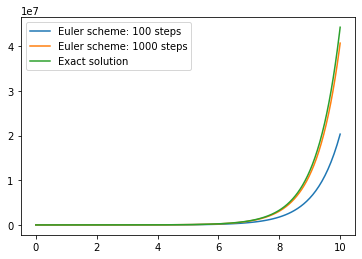

In [4]:
fig, ax = plt.subplots(1, 1)

N = 100  # Number of steps in simulation
t, X_mean = ode_euler(t0, X0, T, a, 100)

ax.plot(t, X_mean, label='Euler scheme: {} steps'.format(N))

N = 1000  # Number of steps in simulation
t, X_mean = ode_euler(t0, X0, T, a, 1000)

ax.plot(t, X_mean, label='Euler scheme: {} steps'.format(N))

# Exact solution

X_mean_exact = X0 * np.exp(mu*(t-t0))

ax.plot(t, X_mean_exact, label='Exact solution')
_ = ax.legend()


## Stochastic Euler integration (Euler- Maruyana) scheme

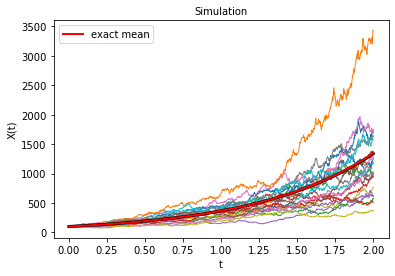

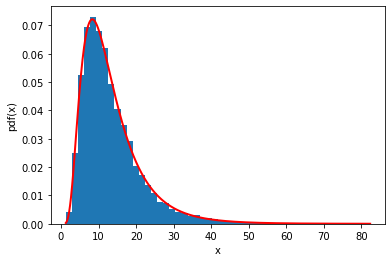

In [5]:
T = 2.0 # Length of simulation interval

# Carry out simulation
t, X_euler = sde.euler_maruyana(t0, X0, T, a, b, M, N)


# Plot trajectories 
stoch.plot_trajectories(t, X_euler, fig_num=1)

# Compare with exact mean

X_mean_exact = X0 * np.exp(mu*(t-t0))

plt.plot(t, X_mean_exact, linewidth=2, color='r', label='exact mean')
plt.legend()

# Plot histogram 
X_T = X_euler[:,-1]
def pdf(x): 
    return stats.lognorm.pdf(x, 
                             sigma*np.sqrt(T), 0.0, 
                             np.exp((mu - 0.5*sigma**2)*T))

stoch.plot_pdf(X_T/X0, pdf, fig_num=2)

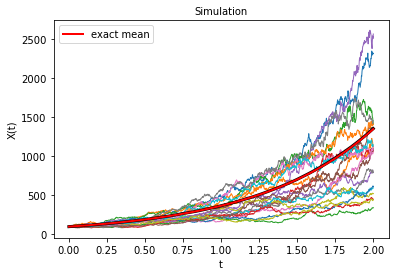

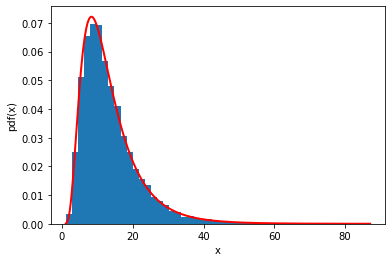

In [6]:
T = 2.0 # Length of simulation interval

# Carry out simulation
t, X_euler = sde.euler_maruyana(t0, X0, T, a, b, M, N)


# Plot trajectories 
stoch.plot_trajectories(t, X_euler, fig_num=1)

# Compare with exact mean

X_mean_exact = X0 * np.exp(mu*(t-t0))

plt.plot(t, X_mean_exact, linewidth=2, color='r', label='exact mean')
plt.legend()

# Plot histogram 
X_T = X_euler[:,-1]
def pdf(x): 
    return stats.lognorm.pdf(x, 
                             sigma*np.sqrt(T), 0.0, 
                             np.exp((mu - 0.5*sigma**2)*T))

stoch.plot_pdf(X_T/X0, pdf, fig_num=2)

## Milstein integration sheme

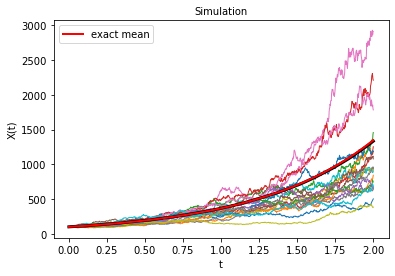

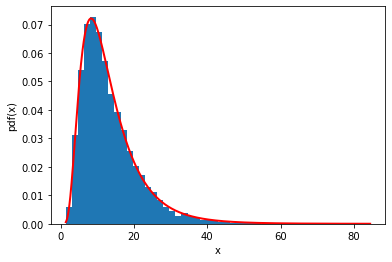

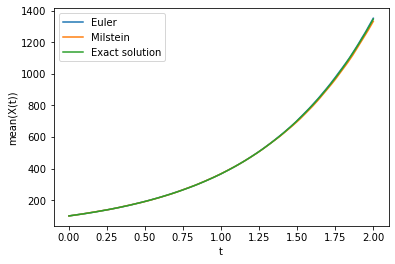

In [7]:
t, X_milstein = sde.milstein(t0, X0, T, a, b, db_dx, M, N)

# Plot trajectories 
stoch.plot_trajectories(t, X_milstein, fig_num=1) 
plt.plot(t, X_mean_exact, linewidth=2, color='r', label='exact mean')
plt.legend()

# Plot histogram 
X_T = X_milstein[:,-1]

stoch.plot_pdf(X_T/X0, pdf, fig_num=2)

# Plot averages of trajectories
fig, ax = plt.subplots(1, 1)

ax.plot(t, np.mean(X_euler, axis=0), label='Euler')
ax.plot(t, np.mean(X_milstein, axis=0), label='Milstein')
ax.plot(t, X_mean_exact, label='Exact solution')
ax.set_xlabel('t')
ax.set_ylabel('mean(X(t))')

_ = ax.legend()

## Jump simulator

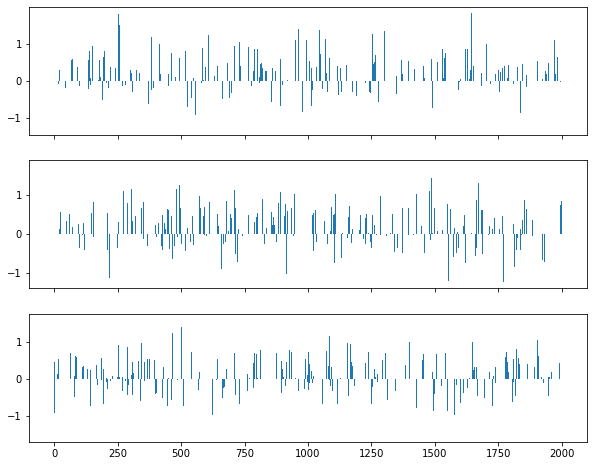

In [8]:
import arrival_process_simulation as arrival
lambda_rate = 0.5
beta_scale = 1.0/lambda_rate 
def simulator_arrival_times(t0, T): 
    return  arrival.simulate_poisson(t0, t0 + T, lambda_rate, M = 1)[0]
def simulator_jump_sizes(N): return 0.2 + 0.5*np.random.randn(N)

def simulator_jump_process(t0, T, M): 
    return sde.simulate_jump_process(t0, T,
                                     simulator_arrival_times, 
                                     simulator_jump_sizes, 
                                     M)

t0 = 0.0
T = 2000.0
M = 3
times_of_jumps, sizes_of_jumps = simulator_jump_process(t0, T, M)

fig, axs = plt.subplots(M, sharex=True, num=1, figsize=(10, 8))
for m in range(M):
     axs[m].bar(times_of_jumps[m], sizes_of_jumps[m])

## Jump-diffusion SDE

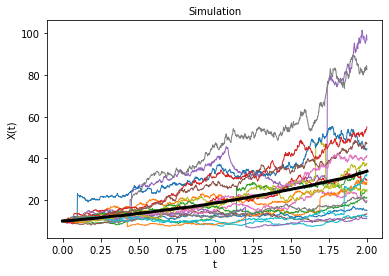

In [9]:
## Define jump-diffusion SDE
def a(t,x): return 5.0*x/x0
def b(t,x): return 3.0*x/x0
def c(t,x): return 10.0*x/x0

## Define the conditions for the simulation

t0 = 0
x0 = 10.0
T = 2.0
N = 1000
M = 500

t, X = sde.euler_jump_diffusion(t0, x0, T, a, b, c, 
                         simulator_jump_process, 
                         M, N)

stoch.plot_trajectories(t, X, fig_num=10)
